**Importing Soap CSV**

In [1]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

import io
soap_df = pd.read_csv(io.BytesIO(uploaded['soap.csv']))

Saving soap.csv to soap.csv


In [2]:
soap_df.head()

,Unnamed: 0,product_category,product_url,review_date,handle,rating,helpfulness_rating,review
0,4000,hand_soap,https://www.amazon.com/dp/B079FV6PRH,10-Sep-19,Summer D Chambers,4,63,"Okay, so I just got my first batch in through ..."
1,4001,hand_soap,https://www.amazon.com/dp/B079FV6PRH,6-Feb-19,dogtown,1,54,"The smell is awful, it smells faintly of nail ..."
2,4002,hand_soap,https://www.amazon.com/dp/B079FV6PRH,7-Jun-20,Largo,5,30,"This is my favorite hand soap, it was sold out..."
3,4003,hand_soap,https://www.amazon.com/dp/B079FV6PRH,10-Jul-20,girl2012,1,26,I love this handsoap. It is the only one I can...
4,4004,hand_soap,https://www.amazon.com/dp/B079FV6PRH,9-Nov-18,J and K,5,45,"I bought these hand soaps for a shop I manage,..."


In [3]:
soap_df = soap_df.drop(columns=['Unnamed: 0', 'product_url', 'review_date', 'handle', 'helpfulness_rating'], axis=1)

In [4]:
soap_df['rating'] = soap_df['rating'].apply(lambda x: 1 if x > 3 else 0)

In [5]:
soap_df.head()

,product_category,rating,review
0,hand_soap,1,"Okay, so I just got my first batch in through ..."
1,hand_soap,0,"The smell is awful, it smells faintly of nail ..."
2,hand_soap,1,"This is my favorite hand soap, it was sold out..."
3,hand_soap,0,I love this handsoap. It is the only one I can...
4,hand_soap,1,"I bought these hand soaps for a shop I manage,..."


**Clean and Preprocess**

In [6]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–","1","2","3","4",
              "5","6","7","8","9","0","xa","le"]

for char in spec_chars:
    soap_df['review'] = soap_df['review'].str.replace(char, ' ')


soap_df['review'] = soap_df['review'].str.split().str.join(" ")

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def tokenize_clean_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    clean_text = nltk.word_tokenize(text)
    clean_text = [token.lower() for token in clean_text if token.lower() not in stop_words]
    clean_text = [lemmatizer.lemmatize(token) for token in clean_text]
    symbols_for_removal = "``~`!@#$%^&*()_-+={[}]|\:;'<,>.?/"
    clean_text = [token for token in clean_text if token not in symbols_for_removal]
    clean_text = str(' ').join(clean_text)
    return clean_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
soap_df['clean_review'] = soap_df.apply(lambda row: tokenize_clean_text(row['review']), axis=1)

In [9]:
soap_df.head()

,product_category,rating,review,clean_review
0,hand_soap,1,Okay so I just got my first batch in through t...,okay got first batch subscribe save unfortunat...
1,hand_soap,0,The smell is awful it smells faintly of nail p...,smell awful smell faintly nail polish remover ...
2,hand_soap,1,This is my favorite hand soap it was sold out ...,favorite hand soap sold everywhere along soap ...
3,hand_soap,0,I love this handsoap It is the only one I can ...,love handsoap one use extremely sensitive skin...
4,hand_soap,1,I bought these hand soaps for a shop I manage ...,bought hand soap shop manage ended keeping one...


**Word Cloud**

In [10]:
Reviews= soap_df.clean_review.to_string(index=False)
Preprocess_reviews = tokenize_clean_text(Reviews)

In [11]:
import nltk
nltk.download('punkt')
import nltk
from nltk.probability import FreqDist

fdist1 = FreqDist(nltk.tokenize.word_tokenize(Preprocess_reviews))

fdist1.most_common(20)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('...', 499),
 ('soap', 345),
 ('great', 255),
 ('hand', 211),
 ('good', 181),
 ('smell', 174),
 ('scent', 164),
 ('price', 125),
 ('love', 123),
 ('product', 104),
 ('like', 97),
 ('’', 80),
 ('bott', 70),
 ('c', 67),
 ('value', 67),
 ('nice', 63),
 ('one', 61),
 ('really', 51),
 ('use', 50),
 ('soft', 45)]

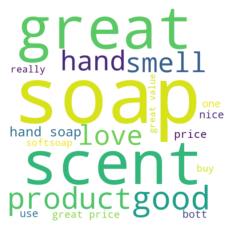

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(min_font_size=25, max_words=500   , background_color="white",width=600,height=600).generate(Preprocess_reviews)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

**Logistic Regression**

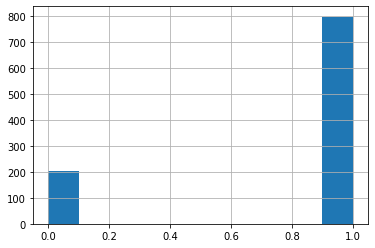

In [13]:
import numpy as np
soap_df['rating'].hist()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDF_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))

TFIDF_vectorizer.fit(soap_df['clean_review'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=None,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [15]:
from sklearn.model_selection import train_test_split

X = soap_df['clean_review']
y = soap_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [16]:
def transform_data(tfidf, dataset):
    features = tfidf.transform(dataset)
    return pd.DataFrame(features.todense(), columns = tfidf.get_feature_names())

X_train_feats = transform_data(TFIDF_vectorizer, X_train)
X_test_feats = transform_data(TFIDF_vectorizer, X_test)

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs')

lr.fit(X_train_feats, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [19]:
y_pred = lr.predict(X_test_feats)

y_pred_prob = lr.predict_proba(X_test_feats)[:, 1]

In [20]:
print('LR Recall: ', round(recall_score(y_test,y_pred),2))
print('LR Precision: ', round(precision_score(y_test,y_pred),2))
print('LR F1: ', round(f1_score(y_test,y_pred),2))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("NB ROC AUC: %.2f" % roc_auc)

LR Recall:  1.0
LR Precision:  0.82
LR F1:  0.9
NB ROC AUC: 0.86


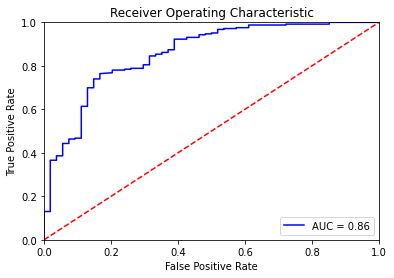

In [21]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Decision Tree**

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train_feats, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [23]:
y_pred_dt = dt.predict(X_test_feats)

y_pred_prob_dt = dt.predict_proba(X_test_feats)[:, 1]

In [24]:
print('DT Recall: ', round(recall_score(y_test,y_pred_dt),2))
print('DT Precision: ', round(precision_score(y_test,y_pred_dt),2))
print('DT F1: ', round(f1_score(y_test,y_pred_dt),2))

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)
print("DT ROC AUC: %.2f" % roc_auc_dt)

DT Recall:  0.91
DT Precision:  0.88
DT F1:  0.9
DT ROC AUC: 0.68


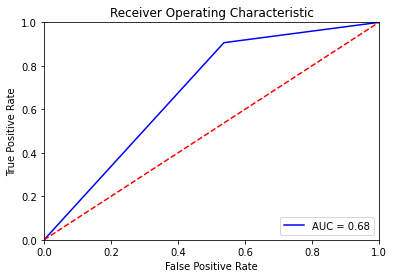

In [25]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_dt, tpr_dt, 'b', label = 'AUC = %0.2f' % roc_auc_dt)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Naive Bayes**

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

nb = GaussianNB()

nb.fit(X_train_feats, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [27]:
y_pred_nb = nb.predict(X_test_feats)
y_pred_prob_nb = nb.predict_proba(X_test_feats)[:, 1]

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

In [28]:
print('NB Recall: ', round(recall_score(y_test,y_pred_nb),2))
print('NB Precision: ', round(precision_score(y_test,y_pred_nb),2))
print('NB F1: ', round(f1_score(y_test,y_pred_nb),2))

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
print("NB ROC AUC: %.2f" % roc_auc_nb)

NB Recall:  0.8
NB Precision:  0.88
NB F1:  0.83
NB ROC AUC: 0.64


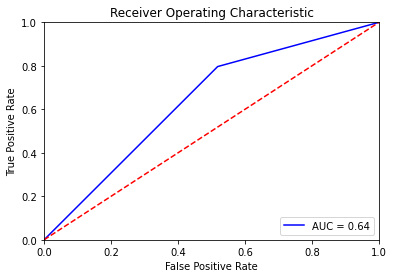

In [29]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_nb, tpr_nb, 'b', label = 'AUC = %0.2f' % roc_auc_nb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()